### Notebook to analyze IFWASTE-Simulation results

In [1]:
import os 
import pandas as pd 
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

In [2]:
PATH = "/blue/carpena/haasehelen/ifwaste/data_old/"
CONFIG_PATH = "/blue/carpena/haasehelen/ifwaste/bash-scripts/experiments/config_0k.json"

In [3]:
CURR_EXP = "22_Jan_0k_0_0"

In [4]:
#PATH = "E:/UF/ifwaste/data/"
#CONFIG_PATH = "E:/UF/ifwaste/model/config.json"

### Loading necessary parameters from config file
- weights per serving of each food category

In [5]:
FGMEAT_KG = FGDAIRY_KG = FGBAKED_KG = FGVEGETABLE_KG = FGDRYFOOD_KG = FGSNACKS_KG = FGSTOREPREPARED_KG = None
with open(CONFIG_PATH) as f:
    config = json.load(f)
    FGMEAT_KG = config["Food"]["FGMeat"]["kg_per_serving"]
    FGDAIRY_KG = config["Food"]["FGDairy"]["kg_per_serving"]
    FGBAKED_KG = config["Food"]["FGBaked"]["kg_per_serving"]
    FGVEGETABLE_KG = config["Food"]["FGVegetable"]["kg_per_serving"]
    FGDRYFOOD_KG = config["Food"]["FGDryFood"]["kg_per_serving"]
    FGSNACKS_KG = config["Food"]["FGSnacks"]["kg_per_serving"]
    FGSTOREPREPARED_KG = config["Food"]["FGStorePrepared"]["kg_per_serving"]
    


In [6]:
lookup_df = pd.DataFrame({
    'Type': ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods', 'Baked Goods' ,
    'Snacks, Condiments, Oils & Other', 'Store-Prepared Items'],
    'Servings_to_Kg': [FGMEAT_KG, FGDAIRY_KG, FGVEGETABLE_KG, FGDRYFOOD_KG, FGBAKED_KG, FGSNACKS_KG, FGSTOREPREPARED_KG],
    "Color": ["#116A65", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#73B55B", "#D82E5E"]
})

status_colors = {
            "Inedible Parts": "#26547C",
            "Plate Waste": "#FFD166",
            "Spoiled Food": "#EF476F"
        }
    
#color_mapping = dict(zip(lookup_df['Type'], lookup_df['Color']))

In [7]:
'''def load_data() -> dict[str, dict[str, dd.DataFrame]]:
    # Dictionary to store DataFrames for each run
    runs_data = {}

    # List of the main folders to process
    main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
    # Iterate over each main folder
    for main_folder in main_folders:
        folder_path = os.path.join(PATH, main_folder)  # type: ignore
        
        # Iterate over each run folder inside the main folder
        for run_folder in os.listdir(folder_path):
            run_path = os.path.join(folder_path, run_folder)
            if os.path.isdir(run_path):
                run_id = run_folder  # Use the folder name as the run ID (e.g., 'run_0')
                # Initialize a dictionary to store DataFrames for each log file in this run
                run_logs = {}
                # Get all CSV files in the run folder
                file_names = [
                    f for f in os.listdir(run_path)
                    if os.path.isfile(os.path.join(run_path, f)) and f.endswith('.csv')
                ]
                
                # Read each CSV file into a Dask DataFrame
                for file in file_names:
                    file_path = os.path.normpath(os.path.join(run_path, file))
                    if os.path.exists(file_path):
                        log_name = file[:-4]  # Remove '.csv' to get the log name
                        run_logs[log_name] = dd.read_csv(file_path,assume_missing=True) #assume all values as floats
                
                # Add the logs dictionary to the runs_data under the current run ID
                runs_data[run_id] = run_logs

    return runs_data
'''

"def load_data() -> dict[str, dict[str, dd.DataFrame]]:\n    # Dictionary to store DataFrames for each run\n    runs_data = {}\n\n    # List of the main folders to process\n    main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]\n    # Iterate over each main folder\n    for main_folder in main_folders:\n        folder_path = os.path.join(PATH, main_folder)  # type: ignore\n        \n        # Iterate over each run folder inside the main folder\n        for run_folder in os.listdir(folder_path):\n            run_path = os.path.join(folder_path, run_folder)\n            if os.path.isdir(run_path):\n                run_id = run_folder  # Use the folder name as the run ID (e.g., 'run_0')\n                # Initialize a dictionary to store DataFrames for each log file in this run\n                run_logs = {}\n                # Get all CSV files in the run folder\n                file_names = [\n                    f for f in os.listdir(run_path)\n         

In [8]:
# List of the main folders to process
MAIN_FOLDERS = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
print(MAIN_FOLDERS)

# all runs (assumed each experiment in mainfoler has the same runs)

EXPERIMENT_KEYS = os.listdir(os.path.join(PATH, MAIN_FOLDERS[0]))
EXPERIMENT_KEYS

['22_Jan_6k', '22_Jan_0k', '22_Jan_2k', '22_Jan_4k']


['run_4',
 'run_8',
 'run_2',
 'run_7',
 'run_5',
 'run_9',
 'run_1',
 'run_6',
 'run_3',
 'run_0']

In [9]:
def load_merged_data() -> dict[str, dd.DataFrame]:
    file_names = ['log_bought', 'log_eaten', 'log_wasted', 'log_hh_config', "log_still_have",
                  "log_hh_daily", "log_sim_config", "log_store_daily"]
    
    data_dict = {}
    
    for main_folder in MAIN_FOLDERS:
        for run_folder in EXPERIMENT_KEYS:
            run_path = os.path.join(PATH + main_folder, run_folder)
            if os.path.isdir(run_path):
                run_id = run_folder.split('_')[-1]

                for csv_type in file_names:
                    file_path = os.path.join(run_path, f'{csv_type}.csv')
                    if os.path.exists(file_path):
                        
                        df = dd.read_csv(file_path, assume_missing=True)
                        df["experiment"] = main_folder
                        df["run"] = run_id
                        
                        if 'household' in df.columns:
                            df["household"] = df["household"].astype(int)
                            df['id'] = main_folder + "_" + run_id + "_" + df['household'].astype(int).astype(str)
                        
                        if "Unnamed: 0" in df.columns:
                            df = df.drop(columns=["Unnamed: 0"])
                        
                        if "day" in df.columns:
                            df["day"] = df["day"].astype(int)
                        
                        
                        if csv_type not in data_dict:
                            data_dict[csv_type] = df
                        else:
                            data_dict[csv_type] = dd.concat([data_dict[csv_type], df], axis=0)

    return data_dict


In [10]:
data = load_merged_data()
#data = load_data()

In [11]:
d = data["log_wasted"].compute()
d

,household,day,price,servings,days_till_expiry,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,experiment,run,id
0,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
1,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
2,24,0,0.000000,0.800000,10.0,Unprepared,Inedible Parts,0.000000,0.000000,0.8,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
3,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
4,24,0,0.000000,0.600000,6.0,Unprepared,Inedible Parts,0.000000,0.000000,0.6,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58425,84,99,0.000000,2.400000,6.0,Unprepared,Inedible Parts,2.400000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58426,84,99,3.079388,5.814895,5.0,Prepared,Plate Waste,1.804623,0.000000,0.0,2.673515,0.501284,0.835473,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58427,84,99,1.605130,3.055139,2.0,Prepared,Plate Waste,0.722558,0.477365,0.0,1.106620,0.032548,0.716048,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58428,84,99,0.011204,0.021325,2.0,Prepared,Plate Waste,0.005044,0.003332,0.0,0.007724,0.000227,0.004998,0.0,22_Jan_4k,0,22_Jan_4k_0_84


In [12]:
d

,household,day,price,servings,days_till_expiry,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,experiment,run,id
0,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
1,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
2,24,0,0.000000,0.800000,10.0,Unprepared,Inedible Parts,0.000000,0.000000,0.8,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
3,24,0,0.000000,0.800000,4.0,Unprepared,Inedible Parts,0.800000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
4,24,0,0.000000,0.600000,6.0,Unprepared,Inedible Parts,0.000000,0.000000,0.6,0.000000,0.000000,0.000000,0.0,22_Jan_6k,4,22_Jan_6k_4_24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58425,84,99,0.000000,2.400000,6.0,Unprepared,Inedible Parts,2.400000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58426,84,99,3.079388,5.814895,5.0,Prepared,Plate Waste,1.804623,0.000000,0.0,2.673515,0.501284,0.835473,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58427,84,99,1.605130,3.055139,2.0,Prepared,Plate Waste,0.722558,0.477365,0.0,1.106620,0.032548,0.716048,0.0,22_Jan_4k,0,22_Jan_4k_0_84
58428,84,99,0.011204,0.021325,2.0,Prepared,Plate Waste,0.005044,0.003332,0.0,0.007724,0.000227,0.004998,0.0,22_Jan_4k,0,22_Jan_4k_0_84


In [13]:
# Number of houses
N_HH = data["log_hh_config"]["household"].max().compute() + 1
N_HH

np.int64(100)

In [14]:

DAYS = int(data["log_sim_config"]["total_days"].max().compute())
DAYS

100

## Sanity Checks: 
1. Biomass check


In [15]:
wasted_df = data["log_wasted"][(data["log_wasted"]["id"] == CURR_EXP)]
wasted_df.head()

/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/dask/dataframe/core.py:8170: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,household,day,price,servings,days_till_expiry,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,experiment,run,id


In [16]:
wasted_df = data["log_wasted"][(data["log_wasted"]["id"] == CURR_EXP)]

# Group by 'day' and 'reason', then sum the 'servings'
wasted_df = wasted_df.groupby(['day', 'reason'])['servings'].sum().reset_index().compute()

# Pivot the table to create a column for each reason, with the sum of servings as values
wasted_df = wasted_df.pivot_table(index='day', columns='reason', values='servings', aggfunc='sum', fill_value=0)

# Reset column names
wasted_df.columns = [f"wasted_{col}" for col in wasted_df.columns]

# Reset index to have 'day' as a column
wasted_df = wasted_df.reset_index()

wasted_df.head()


,day,wasted_Inedible Parts,wasted_Plate Waste,wasted_Spoiled Food
0,0,4.2,2.625896,0.0
1,1,1.0,2.625939,0.0
2,2,0.0,2.625936,0.0
3,3,0.0,2.625896,0.0
4,4,0.0,2.625953,0.0


In [17]:
bought = data["log_bought"][(data["log_bought"]["id"] == CURR_EXP)]
bought = bought["servings"] * bought["amount"]
bought_n = bought.sum().compute()

eaten = data["log_eaten"][(data["log_eaten"]["id"] == CURR_EXP)]
eaten_n = eaten["servings"].sum().compute()

wasted = data["log_wasted"][(data["log_wasted"]["id"] == CURR_EXP)]
wasted_n = wasted["servings"].sum().compute()

left = data["log_still_have"][(data["log_still_have"]["id"] == CURR_EXP)]
left_n= left["servings"].sum().compute()

print("bought total servings:\t\t", int(bought_n))
print("eaten total servings:\t\t", int(eaten_n))
print("wasted total servings:\t\t", int(wasted_n))    
print("left last day in servings:\t", int(left_n))

diff = bought_n - (eaten_n + wasted_n + left_n)

print("bought - consumed:\t\t", diff)
print("------------")

bought total servings:		 4799
eaten total servings:		 3569
wasted total servings:		 1168
left last day in servings:	 61
bought - consumed:		 0.0
------------


/tmp/ipykernel_1045905/3012562132.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  should_eat = DAYS * [float(should_eat)]


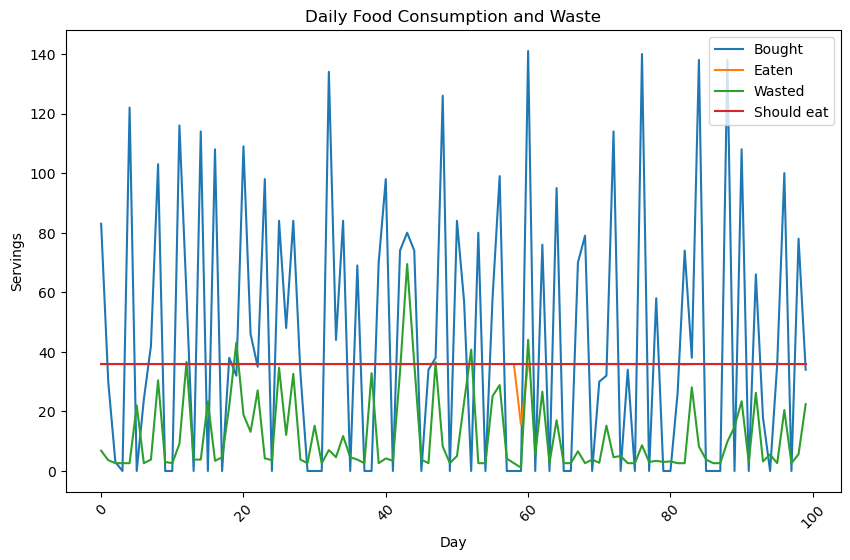

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd 

def calculate_daily_quantities_matrix(data):
    """
    Calculates bought, eaten, wasted, and left quantities for each day 
    using matrix operations (groupby and aggregation) with dask.

    Args:
        data: A dictionary containing dask DataFrames for 'log_bought' and 'log_eaten'.

    Returns:
        A dask DataFrame with columns for 'day', 'bought', 'eaten', 'wasted', and 'left'.
    """

    # Extract dask DataFrames from the dictionary
    log_bought = data["log_bought"][(data["log_bought"]["id"] == CURR_EXP)] #data['log_bought']
    log_eaten = data["log_eaten"][(data["log_eaten"]["id"] == CURR_EXP)] #data['log_eaten'] 

    # Calculate bought 
    bought_df = log_bought.groupby('day')['servings'].sum().compute() 
    bought_df = bought_df.reset_index() 
    bought_df.columns = ['day', 'bought'] 

    # Calculate eaten
    eaten_df = log_eaten.groupby('day')['servings'].sum().compute()
    eaten_df = eaten_df.reset_index()
    eaten_df.columns = ['day', 'eaten'] 

    # Merge bought and eaten DataFrames
    results_df = pd.merge(bought_df, eaten_df, on='day', how='outer') 
    results_df = results_df.fillna(0)  # Fill missing values with 0

    # Assuming 'log_wasted' and 'log_still_have' are also in the dictionary
    if 'log_wasted' in data:
        #log_wasted = data['log_wasted']
        log_wasted = data["log_wasted"][(data["log_wasted"]["id"] == CURR_EXP)]
        wasted_df = log_wasted.groupby('day')['servings'].sum().compute()
        wasted_df = wasted_df.reset_index()
        wasted_df.columns = ['day', 'wasted']
        results_df = pd.merge(results_df, wasted_df, on='day', how='left') 

    results_df = results_df.fillna(0) 

    return results_df


results_df = calculate_daily_quantities_matrix(data) 
#what all houes of  should eat in days
log_config  =data["log_hh_config"][(data["log_hh_config"]["id"] == CURR_EXP)]
should_eat = log_config["required_servings"].compute()
should_eat = DAYS * [float(should_eat)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df["day"], results_df["bought"], label="Bought")
plt.plot(results_df["day"], results_df["eaten"], label="Eaten") 
plt.plot(results_df["day"], results_df["wasted"], label="Wasted") 
plt.plot(range(0,DAYS),should_eat, label="Should eat") 
plt.xlabel("Day")
plt.ylabel("Servings")
plt.title("Daily Food Consumption and Waste")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [19]:
results_df.head(20)

,day,bought,eaten,wasted
0,0,83.0,35.897881,6.825896
1,1,30.0,35.898465,3.625939
2,2,3.0,35.898424,2.625936
3,3,0.0,35.897881,2.625896
4,4,122.0,35.898655,2.625953
5,5,0.0,35.897881,22.026996
6,6,24.0,35.898655,2.625953
7,7,42.0,35.897881,3.825896
8,8,103.0,35.897881,30.447735
9,9,0.0,35.898655,3.025953


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd 

# Extract Dask DataFrames from the dictionary
log_bought = data["log_bought"][(data["log_bought"]["id"] == CURR_EXP)]  # data['log_bought']
bought_df = log_bought[["day", "servings", "amount"]]
bought_df["serv_bought"] = log_bought["servings"] * log_bought["amount"]
bought_df = bought_df.groupby('day')['serv_bought'].sum().reset_index()
bought_df = bought_df.sort_values('day')
bought_df['acc_bought'] = bought_df['serv_bought'].cumsum()
bought_df = bought_df.compute()  # Convert to Pandas DataFrame

log_eaten = data["log_eaten"][(data["log_eaten"]["id"] == CURR_EXP)]  # data['log_eaten']
eaten_df = log_eaten[["day", "servings"]]
eaten_df = eaten_df.groupby('day')['servings'].sum().reset_index()
eaten_df = eaten_df.sort_values('day')
eaten_df['acc_eaten'] = eaten_df['servings'].cumsum()
eaten_df["serv_eaten"] = eaten_df["servings"]
eaten_df = eaten_df.drop(columns=["servings"])

eaten_df = eaten_df.compute()  # Convert to Pandas DataFrame

log_wasted = data["log_wasted"][(data["log_wasted"]["id"] == CURR_EXP)]  # data['log_wasted']
wasted_df = log_wasted[["day", "servings"]]
wasted_df = wasted_df.groupby('day')['servings'].sum().reset_index()
wasted_df = wasted_df.sort_values('day')
wasted_df['acc_wasted'] = wasted_df['servings'].cumsum()
wasted_df["serv_wasted"] = wasted_df["servings"]
wasted_df = wasted_df.compute()  # Convert to Pandas DataFrame

# Merge bought, eaten, and wasted DataFrames
results_df = pd.merge(bought_df, eaten_df, on='day', how='outer')
results_df = pd.merge(results_df, wasted_df, on='day', how='outer')

# Fill missing values with 0
results_df = results_df.fillna(0)

# Get cumulative "should eat" data
log_config = data["log_hh_config"][(data["log_hh_config"]["id"] == CURR_EXP)]



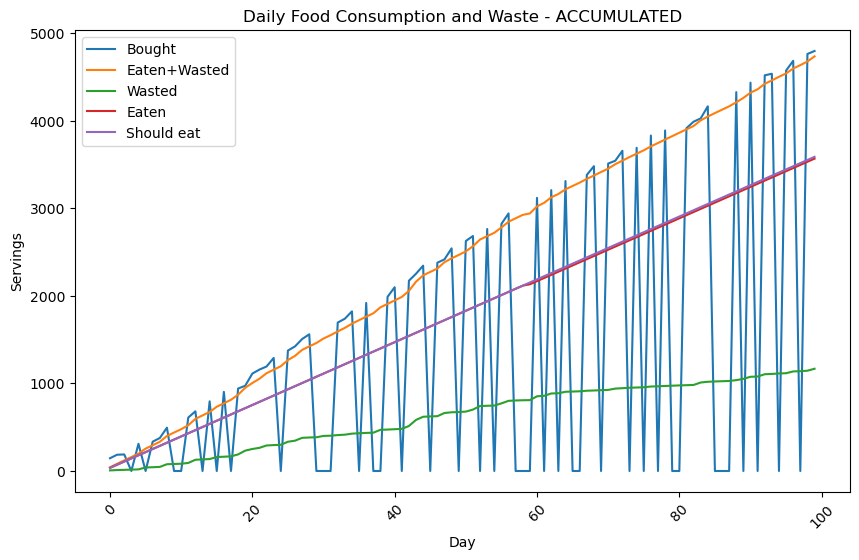

In [21]:
from itertools import accumulate
should_eat = log_config["required_servings"].compute()
should_eat_accumulated = [should_eat * (i + 1) for i in range(DAYS)]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df["day"], results_df["acc_bought"], label="Bought")
plt.plot(results_df["day"], results_df["acc_eaten"] + results_df["acc_wasted"] , label="Eaten+Wasted")
plt.plot(results_df["day"], results_df["acc_wasted"], label="Wasted")
plt.plot(results_df["day"], results_df["acc_eaten"] , label="Eaten")
plt.plot(range(0, DAYS), should_eat_accumulated, label="Should eat")
plt.xlabel("Day")
plt.ylabel("Servings")
plt.title("Daily Food Consumption and Waste - ACCUMULATED")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [22]:
results_df["eat_waste"] = results_df["acc_eaten"] + results_df["acc_wasted"]
results_df.head(100)

,day,serv_bought,acc_bought,acc_eaten,serv_eaten,servings,acc_wasted,serv_wasted,eat_waste
0,0,146.0,146.0,35.897881,35.897881,6.825896,6.825896,6.825896,42.723778
1,1,40.0,186.0,71.796346,35.898465,3.625939,10.451836,3.625939,82.248182
2,2,3.0,189.0,107.694770,35.898424,2.625936,13.077772,2.625936,120.772542
3,3,0.0,0.0,143.592652,35.897881,2.625896,15.703668,2.625896,159.296320
4,4,122.0,311.0,179.491307,35.898655,2.625953,18.329622,2.625953,197.820929
...,...,...,...,...,...,...,...,...,...
95,95,36.0,4575.0,3425.578296,35.898641,2.625952,1117.174975,2.625952,4542.753270
96,96,112.0,4687.0,3461.476177,35.897881,20.476934,1137.651908,20.476934,4599.128085
97,97,0.0,0.0,3497.374831,35.898654,2.625953,1140.277862,2.625953,4637.652693
98,98,78.0,4765.0,3533.272712,35.897881,5.625896,1145.903758,5.625896,4679.176471


In [23]:
## OVER ALL HOUSEHOLDS
bought = data["log_bought"]["servings"] * data["log_bought"]["amount"]
bought = bought.sum().compute()

eaten = data["log_eaten"]["servings"].sum().compute()
wasted = data["log_wasted"]["servings"].sum().compute()
left = data["log_still_have"]["servings"].sum().compute()

print("bought total servings:\t\t", int(bought))
print("eaten total servings:\t\t", int(eaten))
print("wasted total servings:\t\t", int(wasted))    
print("left last day in servings:\t", int(left))

diff = bought - (eaten + wasted + left)

print("bought - consumed:\t\t", diff)
print("------------")

bought total servings:		 31731589
eaten total servings:		 25633764
wasted total servings:		 5916147
left last day in servings:	 181676
bought - consumed:		 0.00012284517288208008
------------


In [24]:
#what all houes of run 0 should eat in days
config  =data["log_hh_config"][(data["log_hh_config"]["id"] == "22_Jan_6k_4_24")]
should_eat = config["required_servings"].compute() * DAYS
should_eat

24    12945.210414
Name: required_servings, dtype: float64

In [25]:
#how much servings are missing over all hh of run 0 over days
daily = data["log_hh_daily"][(data["log_hh_daily"]["id"] == "22_Jan_6k_4_24")]
missing_eat = daily["servings"].sum().compute()
missing_eat


np.float64(3787.0865900403223)

### Preprocess data for per capita and per household baseline values
have a second datastructure in place that has all the hh merged together for some analysis like average waste per household. 

data <- holds data organized by run

data_merged <- holds data organized as 1 big simulation, hh unique through HH+RUN 



In [26]:
data["log_hh_config"].head()

,household,required_servings,budget,adults,children,lvl_of_concern,plate_waste_ratio,avail_time_monday,avail_time_tuesday,avail_time_wednesday,avail_time_thursday,avail_time_friday,avail_time_saturday,avail_time_sunday,shopping_frequency,experiment,run,id
0,0,123.585243,900.0,2.0,6.0,0.388823,0.107327,1.991336,2.427619,1.307512,2.637519,0.379555,2.558394,3.743919,4.0,22_Jan_6k,4,22_Jan_6k_4_0
1,1,122.178657,420.0,2.0,6.0,0.435027,0.081036,2.130135,1.424557,2.269633,2.345570,3.830335,0.110361,2.872110,4.0,22_Jan_6k,4,22_Jan_6k_4_1
2,2,125.330171,360.0,2.0,6.0,0.400171,0.080178,2.910331,2.663155,1.733574,1.655722,3.343380,3.401307,0.659425,4.0,22_Jan_6k,4,22_Jan_6k_4_2
3,3,120.972877,360.0,2.0,6.0,0.415613,0.092054,0.486767,1.166870,3.641950,1.475187,1.765049,1.481999,3.618597,4.0,22_Jan_6k,4,22_Jan_6k_4_3
4,4,132.344553,840.0,2.0,6.0,0.369030,0.101395,2.364274,2.976788,3.265507,0.169550,2.008394,0.400779,1.763238,4.0,22_Jan_6k,4,22_Jan_6k_4_4


In [27]:
data["log_wasted"].head()

,household,day,price,servings,days_till_expiry,status,reason,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,experiment,run,id
0,24,0,0.0,0.8,4.0,Unprepared,Inedible Parts,0.8,0.0,0.0,0.0,0.0,0.0,0.0,22_Jan_6k,4,22_Jan_6k_4_24
1,24,0,0.0,0.8,4.0,Unprepared,Inedible Parts,0.8,0.0,0.0,0.0,0.0,0.0,0.0,22_Jan_6k,4,22_Jan_6k_4_24
2,24,0,0.0,0.8,10.0,Unprepared,Inedible Parts,0.0,0.0,0.8,0.0,0.0,0.0,0.0,22_Jan_6k,4,22_Jan_6k_4_24
3,24,0,0.0,0.8,4.0,Unprepared,Inedible Parts,0.8,0.0,0.0,0.0,0.0,0.0,0.0,22_Jan_6k,4,22_Jan_6k_4_24
4,24,0,0.0,0.6,6.0,Unprepared,Inedible Parts,0.0,0.0,0.6,0.0,0.0,0.0,0.0,22_Jan_6k,4,22_Jan_6k_4_24


### Analyze waste
- check waste per household/ per capita for each day
- check waste per category household/ per capita for each day

In [ ]:
def calculate_waste(dask_df, per_capita,per_reason, per_status):
    # Extract Dask DataFrames
    config_df = dask_df["log_hh_config"].compute()
    wasted = dask_df["log_wasted"]
    
    # Merge data with configuration to get household information
    merged_df = dd.merge(wasted, config_df[['id', 'adults', 'children']], on='id', how='inner')
    merged_df['total_people'] = df_total_waste['adults'] + df_total_waste['children']

    # Group by day and household, then sum waste and normalize if per capita
    df_total_waste = merged_df.groupby(by=['day', 'id'])['servings'].sum().compute()
    df_total_waste = df_total_waste
    df_total_waste = df_total_waste.to_frame(name='total_servings').reset_index()
    
    
    print(df_total_waste["total_people"].unique())
    
    df_total_waste["total_servings_pp"]  = df_total_waste["total_servings"]  / df_total_waste["total_people"] 
    df_total_waste["total_servings"]  = df_total_waste["total_servings"]  
    
    if per_reason: 
        # Group by 'day' and 'reason', then sum the 'servings'
        df_reason = merged_df.groupby(["id",'day', 'reason'])['servings'].sum().reset_index().compute()
        # Pivot the table to create a column for each reason, with the sum of servings as values
        df_reason = df_reason.pivot_table(index=["id",'day'], columns='reason', values='servings', aggfunc='sum', fill_value=0)
        df_reason.columns = [f"wasted_{col}" for col in df_reason.columns]
        
        df_reason["wasted_inedible"] = df_reason["wasted_Inedible Parts"]
        df_reason["wasted_spoiled"] = df_reason["wasted_Spoiled Food"]
        df_reason["wasted_plate_waste"] = df_reason["wasted_Plate Waste"]
        

        df_reason = df_reason.drop(columns=["wasted_Inedible Parts", "wasted_Spoiled Food", "wasted_Plate Waste"])
        df_reason = df_reason.reset_index()
    
    if per_status: 
        # Group by 'day' and 'reason', then sum the 'servings'
        df_status = merged_df.groupby(["id",'day', 'status'])['servings'].sum().reset_index().compute()
        # Pivot the table to create a column for each reason, with the sum of servings as values
        df_status = df_status.pivot_table(index=["id",'day'], columns='status', values='servings', aggfunc='sum', fill_value=0)
        df_status.columns = [f"wasted_{col.lower()}" for col in df_status.columns]
        df_status = df_status.reset_index()


    # Step 1: Get all unique `day` and `id` values
    unique_days = df_total_waste['day'].unique()
    unique_ids = df_total_waste['id'].unique()

    # Step 2: Create a complete set of combinations
    all_combinations = pd.MultiIndex.from_product([unique_days, unique_ids], names=['day', 'id'])
    base_df = pd.DataFrame(index=all_combinations).reset_index()

    # Step 3: Merge both DataFrames with the base DataFrame
    df_merged = base_df.merge(df_total_waste, on=['day', 'id'], how='left').merge(df_reason, on=['day', 'id'], how='left')
    df_merged = base_df.merge(df_merged, on=['day', 'id'], how='left').merge(df_status, on=['day', 'id'], how='left')
    
    df_merged["wasted_inedible_pp"] = df_merged["wasted_inedible"]/df_merged['total_people']
    df_merged["wasted_spoiled_pp"] = df_merged["wasted_spoiled"]/df_merged['total_people']
    df_merged["wasted_plate_waste_pp"] = df_merged["wasted_plate_waste"]/df_merged['total_people']
    
    df_merged["wasted_unprepared_pp"] = df_merged["wasted_unprepared"]/df_merged['total_people']
    df_merged["wasted_preprepared_pp"] = df_merged["wasted_preprepared"]/df_merged['total_people']
    df_merged["wasted_prepared_pp"] = df_merged["wasted_prepared"]/df_merged['total_people']
    
    # Step 4: Fill missing values with 0
    df_merged = df_merged.fillna(0)
    

    return df_merged

In [70]:
def calculate_waste(dask_df, per_capita,per_reason, per_status):
    # Extract Dask DataFrames
    config_df = dask_df["log_hh_config"].compute()
    wasted = dask_df["log_wasted"]
    
    # Merge data with configuration to get household information
    merged_df = dd.merge(wasted, config_df[['id', 'adults', 'children']], on='id', how='inner')
    

    # Group by day and household, then sum waste and normalize if per capita
    df_total_waste = merged_df.groupby(by=['day', 'id'])['servings'].sum().compute()
    df_total_waste = df_total_waste
    df_total_waste = df_total_waste.to_frame(name='total_servings').reset_index()
    
    # Calculate the total number of people
    

    df_total_waste['total_people'] = config_df['adults'][0].values[0] + config_df['children'][0].values[0]
    df_total_waste["total_servings_pp"]  = df_total_waste["total_servings"]  / df_total_waste["total_people"] 
    df_total_waste["total_servings"]  = df_total_waste["total_servings"]  
    
    if per_reason: 
        # Group by 'day' and 'reason', then sum the 'servings'
        df_reason = merged_df.groupby(["id",'day', 'reason'])['servings'].sum().reset_index().compute()
        # Pivot the table to create a column for each reason, with the sum of servings as values
        df_reason = df_reason.pivot_table(index=["id",'day'], columns='reason', values='servings', aggfunc='sum', fill_value=0)
        df_reason.columns = [f"wasted_{col}" for col in df_reason.columns]
        
        df_reason["wasted_inedible"] = df_reason["wasted_Inedible Parts"]
        df_reason["wasted_spoiled"] = df_reason["wasted_Spoiled Food"]
        df_reason["wasted_plate_waste"] = df_reason["wasted_Plate Waste"]
        

        df_reason = df_reason.drop(columns=["wasted_Inedible Parts", "wasted_Spoiled Food", "wasted_Plate Waste"])
        df_reason = df_reason.reset_index()
    
    if per_status: 
        # Group by 'day' and 'reason', then sum the 'servings'
        df_status = merged_df.groupby(["id",'day', 'status'])['servings'].sum().reset_index().compute()
        # Pivot the table to create a column for each reason, with the sum of servings as values
        df_status = df_status.pivot_table(index=["id",'day'], columns='status', values='servings', aggfunc='sum', fill_value=0)
        df_status.columns = [f"wasted_{col.lower()}" for col in df_status.columns]
        df_status = df_status.reset_index()


    # Step 1: Get all unique `day` and `id` values
    unique_days = df_total_waste['day'].unique()
    unique_ids = df_total_waste['id'].unique()

    # Step 2: Create a complete set of combinations
    all_combinations = pd.MultiIndex.from_product([unique_days, unique_ids], names=['day', 'id'])
    base_df = pd.DataFrame(index=all_combinations).reset_index()

    # Step 3: Merge both DataFrames with the base DataFrame
    df_merged = base_df.merge(df_total_waste, on=['day', 'id'], how='left').merge(df_reason, on=['day', 'id'], how='left')
    df_merged = base_df.merge(df_merged, on=['day', 'id'], how='left').merge(df_status, on=['day', 'id'], how='left')
    
    df_merged["wasted_inedible_pp"] = df_merged["wasted_inedible"]/df_merged['total_people']
    df_merged["wasted_spoiled_pp"] = df_merged["wasted_spoiled"]/df_merged['total_people']
    df_merged["wasted_plate_waste_pp"] = df_merged["wasted_plate_waste"]/df_merged['total_people']
    
    df_merged["wasted_unprepared_pp"] = df_merged["wasted_unprepared"]/df_merged['total_people']
    df_merged["wasted_preprepared_pp"] = df_merged["wasted_preprepared"]/df_merged['total_people']
    df_merged["wasted_prepared_pp"] = df_merged["wasted_prepared"]/df_merged['total_people']
    
    # Step 4: Fill missing values with 0
    df_merged = df_merged.fillna(0)
    

    return df_merged

In [71]:
waste_df = calculate_waste(data,True, True, True)

/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/dask/dataframe/multi.py:521: UserWarning: Merging dataframes with merge column data type mismatches: 
+---------------+------------+-------------+
| Merge columns | left dtype | right dtype |
+---------------+------------+-------------+
| ('id', 'id')  | object     | string      |
+---------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


KeyboardInterrupt: 

In [72]:
waste_df_all = calculate_waste(data,False, True, True)

/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/dask/dataframe/multi.py:521: UserWarning: Merging dataframes with merge column data type mismatches: 
+---------------+------------+-------------+
| Merge columns | left dtype | right dtype |
+---------------+------------+-------------+
| ('id', 'id')  | object     | string      |
+---------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


In [73]:
waste_df["total_people"].unique()

array([8., 0.])

In [74]:

waste_df.head(10)

,day,id,total_servings,total_people,total_servings_pp,wasted_inedible,wasted_spoiled,wasted_plate_waste,wasted_prepared,wasted_preprepared,wasted_unprepared,wasted_inedible_pp,wasted_spoiled_pp,wasted_plate_waste_pp,wasted_unprepared_pp,wasted_preprepared_pp,wasted_prepared_pp
0,0,22_Jan_4k_2_0,5.098882,8.0,0.637360,1.2,0.0,3.898882,3.898882,0.000000,1.2,0.150,0.0,0.487360,0.150,0.000000,0.487360
1,0,22_Jan_4k_2_11,7.448889,8.0,0.931111,0.0,0.0,7.448889,7.409655,0.039233,0.0,0.000,0.0,0.931111,0.000,0.004904,0.926207
2,0,22_Jan_4k_2_16,20.466490,8.0,2.558311,11.2,0.0,9.266490,9.265983,0.000507,11.2,1.400,0.0,1.158311,1.400,0.000063,1.158248
3,0,22_Jan_4k_2_24,16.996862,8.0,2.124608,9.2,0.0,7.796862,7.796862,0.000000,9.2,1.150,0.0,0.974608,1.150,0.000000,0.974608
4,0,22_Jan_4k_2_30,18.692264,8.0,2.336533,7.2,0.0,11.492264,5.585331,5.906932,7.2,0.900,0.0,1.436533,0.900,0.738367,0.698166
5,0,22_Jan_4k_2_32,7.307013,8.0,0.913377,1.8,0.0,5.507013,5.507013,0.000000,1.8,0.225,0.0,0.688377,0.225,0.000000,0.688377
6,0,22_Jan_4k_2_33,18.674799,8.0,2.334350,8.8,0.0,9.874799,9.874799,0.000000,8.8,1.100,0.0,1.234350,1.100,0.000000,1.234350
7,0,22_Jan_4k_2_38,13.723793,8.0,1.715474,4.6,0.0,9.123793,4.321797,4.801996,4.6,0.575,0.0,1.140474,0.575,0.600250,0.540225
8,0,22_Jan_4k_2_46,14.673110,8.0,1.834139,5.0,0.0,9.673110,5.267535,4.405575,5.0,0.625,0.0,1.209139,0.625,0.550697,0.658442
9,0,22_Jan_4k_2_59,13.138391,8.0,1.642299,2.4,0.0,10.738391,7.072993,3.665397,2.4,0.300,0.0,1.342299,0.300,0.458175,0.884124


In [75]:
print(waste_df["total_servings"].mean())
print(waste_df["total_servings"].std())
print(waste_df["total_servings"].max())

14.79036982407237
18.03930654904555
311.7781465798771


In [76]:
df_filtered = waste_df[waste_df['id'] == "22_Jan_0k_1_0"]

print("mean: ", df_filtered["total_servings"].mean())
print("std: ", df_filtered["total_servings"].std())
print("max: ", df_filtered["total_servings"].max())

mean:  9.823812439355738
std:  12.67819896037888
max:  55.24036627221407


In [81]:
df_filtered.head()

,day,id,total_servings,total_people,total_servings_pp,wasted_inedible,wasted_spoiled,wasted_plate_waste,wasted_prepared,wasted_preprepared,wasted_unprepared,wasted_inedible_pp,wasted_spoiled_pp,wasted_plate_waste_pp,wasted_unprepared_pp,wasted_preprepared_pp,wasted_prepared_pp
1000,0,22_Jan_2k_1_0,14.081611,8.0,1.760201,8.8,0.0,5.281611,5.255004,0.026607,8.8,1.100,0.0,0.660201,1.100,0.003326,0.656876
5000,1,22_Jan_2k_1_0,5.281612,8.0,0.660201,0.0,0.0,5.281612,0.481735,4.799877,0.0,0.000,0.0,0.660201,0.000,0.599985,0.060217
9000,2,22_Jan_2k_1_0,5.281582,8.0,0.660198,0.0,0.0,5.281582,5.281582,0.000000,0.0,0.000,0.0,0.660198,0.000,0.000000,0.660198
13000,3,22_Jan_2k_1_0,4.681947,8.0,0.585243,0.0,0.0,4.681947,4.681947,0.000000,0.0,0.000,0.0,0.585243,0.000,0.000000,0.585243
17000,4,22_Jan_2k_1_0,12.281611,8.0,1.535201,7.0,0.0,5.281611,5.281611,0.000000,7.0,0.875,0.0,0.660201,0.875,0.000000,0.660201


In [77]:
df_filtered = waste_df[waste_df['id'] == "22_Jan_2k_1_0"]

print("mean: ", df_filtered["total_servings"].mean())
print("std: ", df_filtered["total_servings"].std())
print("max: ", df_filtered["total_servings"].max())

mean:  10.684587581475096
std:  15.74724152624911
max:  91.30674411392933


In [78]:
def plot_stacked_waste_reason(data,id): 
    df_filtered = data[data['id'] == id]
    print("mean: ", df_filtered["total_servings"].mean())
    print("std: ", df_filtered["total_servings"].std())
    print("max: ", df_filtered["total_servings"].max())
    
    plt.figure(figsize=(12, 6))

    plt.bar(df_filtered['day'], df_filtered['wasted_inedible'], label='Inedible')
    plt.bar(df_filtered['day'], df_filtered['wasted_spoiled'], label='Spoiled', bottom=df_filtered['wasted_inedible'])
    plt.bar(df_filtered['day'], df_filtered['wasted_plate_waste'], label='Plate Waste',bottom=df_filtered['wasted_inedible'] + df_filtered['wasted_spoiled']
    )

    plt.title(f"Daily Waste Breakdown for ID: {id}")
    plt.xlabel("Time in days")
    plt.ylabel("Waste Amount in servings")
    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.show()

In [35]:
df_filtered = waste_df[waste_df['id'] == "22_Jan_0k_0_0"]
df_filtered

,day,id,total_servings,total_people,total_servings_pp,wasted_inedible,wasted_spoiled,wasted_plate_waste,wasted_prepared,wasted_preprepared,wasted_unprepared,wasted_inedible_pp,wasted_spoiled_pp,wasted_plate_waste_pp,wasted_unprepared_pp,wasted_preprepared_pp,wasted_prepared_pp
1916,0,22_Jan_0k_0_0,6.825896,8.0,0.853237,4.200000,0.000000,2.625896,2.625896,0.000000,4.2,0.525000,0.000000,0.328237,0.525,0.000000,0.328237
5916,1,22_Jan_0k_0_0,3.625939,8.0,0.453242,1.000000,0.000000,2.625939,1.979730,0.646210,1.0,0.125000,0.000000,0.328242,0.125,0.080776,0.247466
9916,2,22_Jan_0k_0_0,2.625936,8.0,0.328242,0.000000,0.000000,2.625936,0.990024,1.635912,0.0,0.000000,0.000000,0.328242,0.000,0.204489,0.123753
13916,3,22_Jan_0k_0_0,2.625896,8.0,0.328237,0.000000,0.000000,2.625896,2.613752,0.012144,0.0,0.000000,0.000000,0.328237,0.000,0.001518,0.326719
17916,4,22_Jan_0k_0_0,2.625953,8.0,0.328244,0.000000,0.000000,2.625953,1.183472,1.442481,0.0,0.000000,0.000000,0.328244,0.000,0.180310,0.147934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381916,95,22_Jan_0k_0_0,2.625952,8.0,0.328244,0.000000,0.000000,2.625952,2.625715,0.000237,0.0,0.000000,0.000000,0.328244,0.000,0.000030,0.328214
385916,96,22_Jan_0k_0_0,20.476934,8.0,2.559617,3.285104,14.565934,2.625896,5.464790,12.012144,3.0,0.410638,1.820742,0.328237,0.375,1.501518,0.683099
389916,97,22_Jan_0k_0_0,2.625953,8.0,0.328244,0.000000,0.000000,2.625953,1.820378,0.805575,0.0,0.000000,0.000000,0.328244,0.000,0.100697,0.227547
393916,98,22_Jan_0k_0_0,5.625896,8.0,0.703237,3.000000,0.000000,2.625896,2.613752,0.012144,3.0,0.375000,0.000000,0.328237,0.375,0.001518,0.326719


mean:  11.683514932895841
std:  13.06880090481908
max:  69.46851884179014


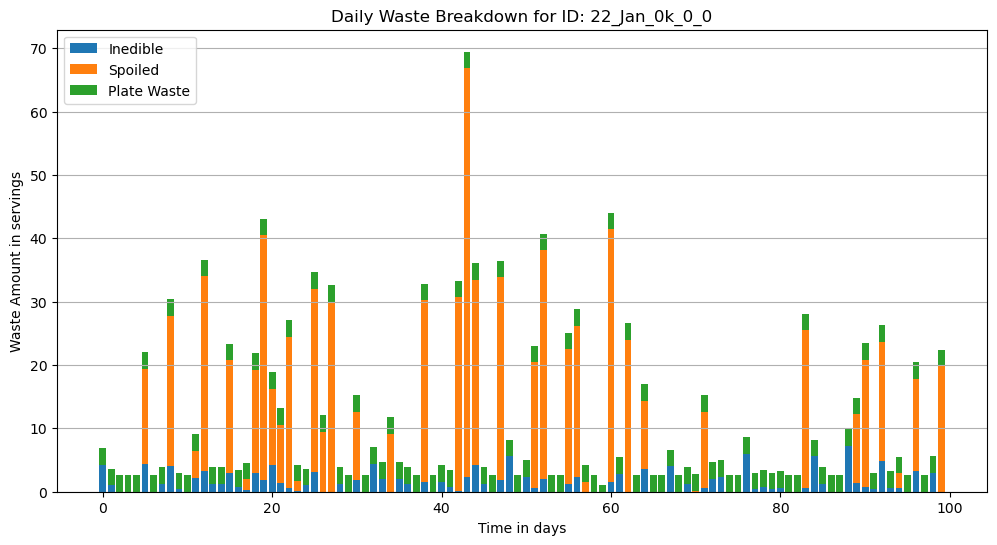

mean:  14.431367281903881
std:  18.02885168207796
max:  95.1183324709683


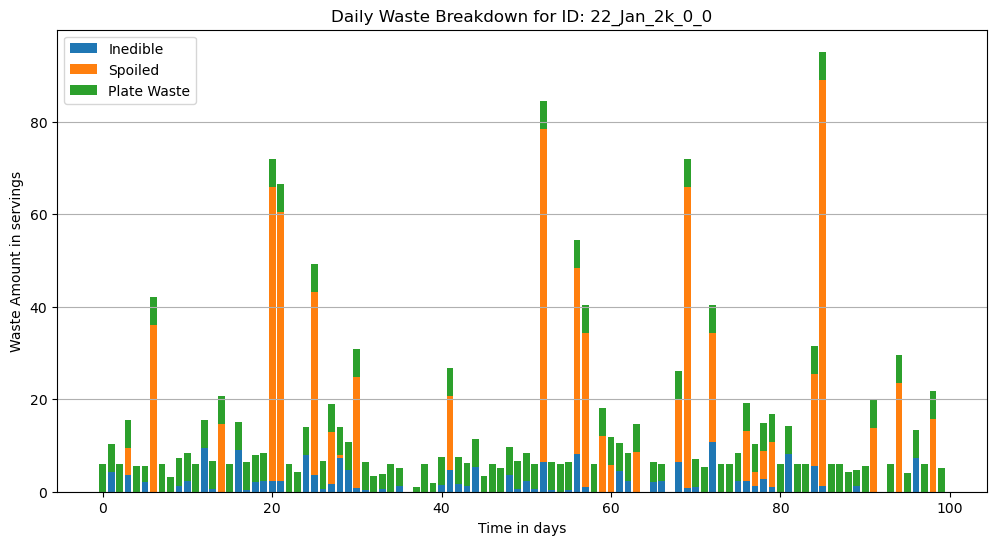

mean:  11.911294715342308
std:  15.802342458770628
max:  78.92530954305583


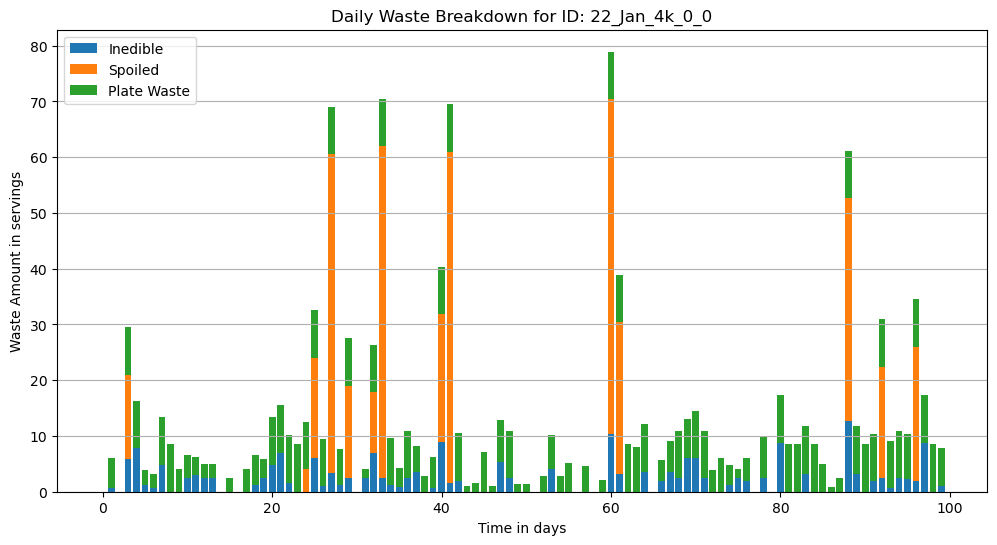

mean:  22.867543180699798
std:  29.025763974393204
max:  142.07991297081804


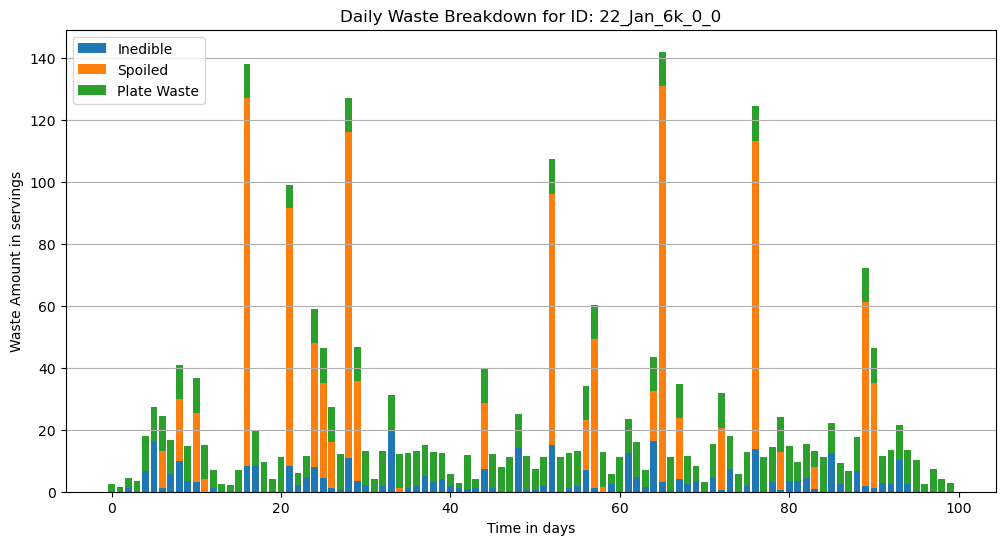

In [80]:
plot_stacked_waste_reason(waste_df_all, "22_Jan_0k_0_0")
plot_stacked_waste_reason(waste_df_all, "22_Jan_2k_0_0")
plot_stacked_waste_reason(waste_df_all, "22_Jan_4k_0_0")
plot_stacked_waste_reason(waste_df_all, "22_Jan_6k_0_0")

In [37]:
def add_concern_intervals(all_data, my_df, interval_labels):
    config_df = data['log_hh_config'].compute()
    config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
    # Merge data for the specific category
    merged_df = pd.merge(
        my_df, 
        config_df[['id', 'concern_interval']],
        on='id', how='inner'
    )
    
    return merged_df


In [38]:

# Calculate the average daily amount eaten per person grouped by LevelOfConcern intervals
bins = [i / 10 for i in range(11)] #10% increments
# Define intervals for x-axis labels
intervals = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']
interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
interval_waste = add_concern_intervals(data,waste_df,interval_labels)
#average_wasted_by_concern = calculate_average_daily(data,bins=bins,category="wasted", per_capita=True)
#average_bought_by_concern = calculate_average_daily(data,bins=bins,category="bought", per_capita=True)

#average_eaten_by_concern_hh = calculate_average_daily(data,bins=bins,category="eaten", per_capita=False)
#average_wasted_by_concern_hh = calculate_average_daily(data,bins=bins,category="wasted", per_capita=False)
#average_bought_by_concern_hh = calculate_average_daily(data,bins=bins,category="bought", per_capita=False)


In [39]:
print(interval_waste["concern_interval"].unique())
interval_waste.head()


[(0.4, 0.5], (0.3, 0.4], (0.5, 0.6], (0.6, 0.7]]
Categories (10, interval[float64, right]): [(0.0, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]


,day,id,total_servings,total_people,total_servings_pp,wasted_inedible,wasted_spoiled,wasted_plate_waste,wasted_prepared,wasted_preprepared,wasted_unprepared,wasted_inedible_pp,wasted_spoiled_pp,wasted_plate_waste_pp,wasted_unprepared_pp,wasted_preprepared_pp,wasted_prepared_pp,concern_interval
0,0,22_Jan_4k_2_0,5.098882,8.0,0.637360,1.2,0.0,3.898882,3.898882,0.000000,1.2,0.15,0.0,0.487360,0.15,0.000000,0.487360,"(0.4, 0.5]"
1,0,22_Jan_4k_2_11,7.448889,8.0,0.931111,0.0,0.0,7.448889,7.409655,0.039233,0.0,0.00,0.0,0.931111,0.00,0.004904,0.926207,"(0.4, 0.5]"
2,0,22_Jan_4k_2_16,20.466490,8.0,2.558311,11.2,0.0,9.266490,9.265983,0.000507,11.2,1.40,0.0,1.158311,1.40,0.000063,1.158248,"(0.4, 0.5]"
3,0,22_Jan_4k_2_24,16.996862,8.0,2.124608,9.2,0.0,7.796862,7.796862,0.000000,9.2,1.15,0.0,0.974608,1.15,0.000000,0.974608,"(0.4, 0.5]"
4,0,22_Jan_4k_2_30,18.692264,8.0,2.336533,7.2,0.0,11.492264,5.585331,5.906932,7.2,0.90,0.0,1.436533,0.90,0.738367,0.698166,"(0.4, 0.5]"


In [55]:
interval_waste["total_people"].unique()

array([8., 0.])

In [54]:
# Step 1: Aggregate total_servings over 100 days for each id
aggregated_by_id = interval_waste.groupby("id", as_index=False).agg({
    "total_servings": "sum",
    "concern_interval": "first",#use first concern interval as value
    "total_people": "first" #CHECK ALWAYS if first works!!! 
})
print(aggregated_by_id.head())
print(len(aggregated_by_id))
### SPACE TO AGGREGATE DEPENDING ON FEATURE

aggregated_by_id = aggregated_by_id.groupby("total_people", as_index=False).agg({
    "total_servings": "sum",
    "concern_interval":"first",
    "id":"first"
})
print(aggregated_by_id.head())
print(len(aggregated_by_id)) ###

# Step 2: Aggregate by concern_interval
aggregated_by_id = aggregated_by_id.groupby("concern_interval", as_index=False).agg({
    "total_servings": "sum"
})
print(aggregated_by_id.head())
print(len(aggregated_by_id))
# Convert the 'concern_interval' to the midpoint for plotting
aggregated_by_id['midpoint'] = aggregated_by_id['concern_interval'].apply(lambda x: x.mid)

# Step 3: Count the number of unique 'id' values in each 'concern_interval'
unique_ids_count = aggregated_by_id.groupby("concern_interval")["id"].nunique()
# Step 4: Merge the unique id counts with the aggregated_by_id DataFrame
aggregated_by_id = aggregated_by_id.merge(unique_ids_count, on="concern_interval", how="left")
aggregated_by_id = aggregated_by_id.rename(columns={"id": "count"})

# Step 5: Divide the total_servings by the count of unique ids in that interval
aggregated_by_id["servings_per_hh"] = 0
aggregated_by_id["servings_per_hh"] = aggregated_by_id["total_servings"] / aggregated_by_id["count"]


# Step 3: Plot the trend line using the midpoint of the concern_interval
plt.figure(figsize=(8, 5))
plt.plot(aggregated_by_id['midpoint'], aggregated_by_id['servings_per_hh'], marker='o', linestyle='-', color='b')

plt.title("Trend of Concern Interval vs. Total Servings")
plt.xlabel("Concern Interval (Midpoint)")
plt.ylabel("Total Servings")
plt.xticks(rotation=45)
plt.xlim(0,1)  # Set x-range from 2 to 8
plt.grid()
plt.tight_layout()
plt.show()


               id  total_servings concern_interval  total_people
0   22_Jan_0k_0_0     1168.351493       (0.4, 0.5]           8.0
1   22_Jan_0k_0_1     1796.131892       (0.4, 0.5]           8.0
2  22_Jan_0k_0_10      537.881929       (0.5, 0.6]           0.0
3  22_Jan_0k_0_11      952.035148       (0.5, 0.6]           8.0
4  22_Jan_0k_0_12     1544.971084       (0.5, 0.6]           8.0
4000
   total_people  total_servings concern_interval              id
0           0.0    9.259256e+05       (0.5, 0.6]  22_Jan_0k_0_10
1           8.0    4.990222e+06       (0.4, 0.5]   22_Jan_0k_0_0
2
  concern_interval  total_servings
0       (0.0, 0.1]    0.000000e+00
1       (0.1, 0.2]    0.000000e+00
2       (0.2, 0.3]    0.000000e+00
3       (0.3, 0.4]    0.000000e+00
4       (0.4, 0.5]    4.990222e+06
10


KeyError: 'Column not found: id'

In [ ]:
# Step 1: Aggregate total_servings over 100 days for each id
aggregated_by_id = interval_waste.groupby("id", as_index=False).agg({
    "total_servings": "sum"
})

print(aggregated_by_id.columns)

### SPACE TO AGGREGATE DEPENDING ON FEATURE

aggregated_by_id = aggregated_by_id.groupby("total_people", as_index=False).agg({
    "total_servings": "sum"
})
###

# Step 2: Aggregate by concern_interval
aggregated_by_interval = aggregated_by_id.groupby("concern_interval", as_index=False).agg({
    "total_servings": "sum"
})

# Convert the 'concern_interval' to the midpoint for plotting
aggregated_by_interval['midpoint'] = aggregated_by_interval['concern_interval'].apply(lambda x: x.mid)

# Step 3: Count the number of unique 'id' values in each 'concern_interval'
unique_ids_count = aggregated_by_id.groupby("concern_interval")["id"].nunique()
# Step 4: Merge the unique id counts with the aggregated_by_interval DataFrame
aggregated_by_interval = aggregated_by_interval.merge(unique_ids_count, on="concern_interval", how="left")
aggregated_by_interval = aggregated_by_interval.rename(columns={"id": "count"})

# Step 5: Divide the total_servings by the count of unique ids in that interval
aggregated_by_interval["servings_per_hh"] = 0
aggregated_by_interval["servings_per_hh"] = aggregated_by_interval["total_servings"] / aggregated_by_interval["count"]


# Step 3: Plot the trend line using the midpoint of the concern_interval
plt.figure(figsize=(8, 5))
plt.plot(aggregated_by_interval['midpoint'], aggregated_by_interval['servings_per_hh'], marker='o', linestyle='-', color='b')

plt.title("Trend of Concern Interval vs. Total Servings")
plt.xlabel("Concern Interval (Midpoint)")
plt.ylabel("Total Servings")
plt.xticks(rotation=45)
plt.xlim(0,1)  # Set x-range from 2 to 8
plt.grid()
plt.tight_layout()
plt.show()


In [80]:
aggregated_by_interval.head()

,concern_interval,total_servings,midpoint,count,servings_per_hh
0,"(0.0, 0.1]",0.000000e+00,0.05,0,NaN
1,"(0.1, 0.2]",0.000000e+00,0.15,0,NaN
2,"(0.2, 0.3]",0.000000e+00,0.25,0,NaN
3,"(0.3, 0.4]",9.423782e+05,0.35,524,1798.431601
4,"(0.4, 0.5]",4.453108e+06,0.45,2942,1513.632740


In [78]:
import matplotlib.pyplot as plt

# Example: Pass the secondary factor column name
feature_column = "total_people"  # Replace with your actual column name

# Step 1: Aggregate total_servings over 100 days for each id
aggregated_by_id = interval_waste.groupby("id", as_index=False).agg({
    "total_servings": "sum",
    "concern_interval": "first",  # Use first concern interval as value
    feature_column: "first"       # Include the secondary factor
})

# Step 2: Aggregate by concern_interval and the secondary factor
aggregated_by_interval = (
    aggregated_by_id.groupby(["concern_interval", feature_column], as_index=False)
    .agg({
        "total_servings": "sum",
        "id": "nunique"  # Count unique IDs
    })
    .rename(columns={"id": "count"})
)

# Step 3: Divide total_servings by the count of unique ids
aggregated_by_interval["servings_per_hh"] = (
    aggregated_by_interval["total_servings"] / aggregated_by_interval["count"]
)

# Step 4: Convert the 'concern_interval' to the midpoint for plotting
aggregated_by_interval["midpoint"] = aggregated_by_interval["concern_interval"].apply(lambda x: x.mid)

# Step 5: Plot the trend lines for each secondary factor
plt.figure(figsize=(10, 6))
for factor_value, subset in aggregated_by_interval.groupby(feature_column):
    plt.plot(
        subset["midpoint"], 
        subset["servings_per_hh"], 
        marker="o", 
        linestyle="-", 
        label=str(factor_value)
    )

# Step 6: Customize the plot
plt.title("Trend of Concern Interval vs. Servings per Household")
plt.xlabel("Concern Interval (Midpoint)")
plt.ylabel("Servings per Household")
plt.legend(title=feature_column)  # Add legend for secondary factor
plt.xticks(rotation=45)
plt.xlim(0, 1)  # Adjust x-range
plt.grid()
plt.tight_layout()
plt.show()


ValueError: Length of values (8) does not match length of index (20)